# Información del grupo

**GRUPO 06**


**Integrantes**:


*   [106675] Gino Oggero - goggero@fi.uba.ar
*   [intercambio] Rita Castro Lobo - ritacastrolobo@tecnico.ulisboa.pt
* [intercambio] Isabella Schneider - ischneider.ext@fi.uba.ar


# Enunciado del problema

En esta notebook, utilizaremos datos de distintas estaciones meteorológicas de Australia. El objetivo es predecir si lloverá o no al día siguiente en función de los datos meteorológicos del día actual. En particular, se analizarán las regiones de Victoria, Territorio del Norte, Australia Meridional, Australia Occidental y Tasmania. Entrenaremos tres modelos (Árboles de Decisión, Random Forest y Regresión Logística) y evaluaremos cuál de ellos es el más eficaz para predecir nuestro target.

# Importamos librerías

In [343]:
!pip install 'dtreeviz'

In [344]:
# Importar librerías para manipulación de datos
import pandas as pd
import numpy as np
import time

# Importar librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz.trees as dtreeviz

# Importar modelos y métricas
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_curve, roc_curve, precision_score,
                             recall_score, accuracy_score, f1_score,
                             roc_auc_score, auc)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Importar preprocesamiento
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import xgboost as xgb


# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


# Funciones utilizadas

In [345]:
def graficar_boxplots(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_columns = len(numeric_columns)
    num_rows = (num_columns // 4) + (num_columns % 4 > 0)

    plt.figure(figsize=(15, 4 * num_rows))

    for i, column in enumerate(numeric_columns, 1):
        plt.subplot(num_rows, 4, i)
        sns.boxplot(x=df[column], color='skyblue')
        plt.title(f'Boxplot de {column}')

    plt.tight_layout()
    plt.show()

In [346]:
def plotear_grafico(df_to_graph, title, xlabel, ylabel):

  plt.figure(figsize=(10, 6))
  df_to_graph.plot(kind="bar")
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xticks(rotation=90)
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.tight_layout()
  plt.show()

In [347]:
def entrenar_modelo_con_busqueda_aleatoria_test(modelo, espacio_parametros, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba, skf):
    # Inicializar RandomizedSearchCV
    busqueda_aleatoria = RandomizedSearchCV(modelo, param_distributions=espacio_parametros, n_iter=10,
                                            scoring='accuracy', n_jobs=-1, cv=skf)

    # Ajustar el modelo utilizando RandomizedSearchCV
    busqueda_aleatoria.fit(x_entrenamiento, y_entrenamiento)

    # Obtener el mejor estimador
    mejor_modelo = busqueda_aleatoria.best_estimator_
    # Obtener los mejores parámetros
    mejores_parametros = busqueda_aleatoria.best_params_

    # Predecir en el conjunto de prueba
    y_predicciones = mejor_modelo.predict(x_prueba)

    # Calcular métricas de evaluación
    exactitud = accuracy_score(y_prueba, y_predicciones)
    precision = precision_score(y_prueba, y_predicciones, average='weighted')  # Calcular precisión
    recall = recall_score(y_prueba, y_predicciones, average='weighted')  # Calcular recall
    f1 = f1_score(y_prueba, y_predicciones, average='weighted')
    auc_roc = roc_auc_score(y_prueba, y_predicciones)

    # Mostrar resultados de las métricas
    print('Exactitud (Accuracy): ', exactitud)
    print('Precisión (Precision): ', precision)
    print('Sensibilidad (Recall): ', recall)
    print('Puntuación F1: ', f1)
    print('AUC(ROC): ', auc_roc)
    print()
    print("Informe de Clasificación: ")
    print(classification_report(y_prueba, y_predicciones))

    # Curva ROC AUC
    probabilidades = mejor_modelo.predict_proba(x_prueba)
    probabilidades = probabilidades[:, 1]
    tasa_falsos_positivos, tasa_verdaderos_positivos, _ = roc_curve(y_prueba, probabilidades)
    puntuacion_auc = auc(tasa_falsos_positivos, tasa_verdaderos_positivos)

    # Graficar resultados
    fig, ejes = plt.subplots(1, 2, figsize=(12, 6))

    # Graficar la curva ROC
    ejes[0].plot(tasa_falsos_positivos, tasa_verdaderos_positivos, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % puntuacion_auc)
    ejes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ejes[0].set_xlabel('Tasa de Falsos Positivos')
    ejes[0].set_ylabel('Tasa de Verdaderos Positivos')
    ejes[0].set_title('Curva Característica de Operación del Receptor (ROC)')
    ejes[0].legend(loc="lower right")

    # Graficar la matriz de confusión
    sns.heatmap(confusion_matrix(y_prueba, y_predicciones), ax=ejes[1], annot=True, cbar=False, fmt='.0f')
    ejes[1].set_xlabel('Etiquetas Predichas')
    ejes[1].set_ylabel('Etiquetas Reales')

    plt.show()

    # Retornar métricas de evaluación
    return modelo, exactitud, precision, recall, f1, auc_roc, mejores_parametros



In [348]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

def entrenar_modelo_con_busqueda_aleatoria_train(modelo, espacio_parametros, x_entrenamiento, y_entrenamiento, skf):
    # Inicializar RandomizedSearchCV
    busqueda_aleatoria = RandomizedSearchCV(modelo, param_distributions=espacio_parametros, n_iter=10,
                                            scoring='accuracy', n_jobs=-1, cv=skf)

    # Ajustar el modelo utilizando RandomizedSearchCV
    busqueda_aleatoria.fit(x_entrenamiento, y_entrenamiento)

    # Obtener el mejor estimador
    mejor_modelo = busqueda_aleatoria.best_estimator_
    # Obtener los mejores parámetros
    mejores_parametros = busqueda_aleatoria.best_params_

    # Predecir en el conjunto de entrenamiento
    y_predicciones_train = mejor_modelo.predict(x_entrenamiento)

    # Calcular métricas de evaluación para el conjunto de entrenamiento
    exactitud_train = accuracy_score(y_entrenamiento, y_predicciones_train)
    precision_train = precision_score(y_entrenamiento, y_predicciones_train, average='weighted')
    recall_train = recall_score(y_entrenamiento, y_predicciones_train, average='weighted')
    f1_train = f1_score(y_entrenamiento, y_predicciones_train, average='weighted')
    auc_roc_train = roc_auc_score(y_entrenamiento, y_predicciones_train)

    # Mostrar resultados de las métricas para el conjunto de entrenamiento
    print('--- Métricas del Conjunto de Entrenamiento ---')
    print('Exactitud (Accuracy): ', exactitud_train)
    print('Precisión (Precision): ', precision_train)
    print('Sensibilidad (Recall): ', recall_train)
    print('Puntuación F1: ', f1_train)
    print('AUC(ROC): ', auc_roc_train)
    print()
    print("Informe de Clasificación para el Conjunto de Entrenamiento: ")
    print(classification_report(y_entrenamiento, y_predicciones_train))

    # Retornar métricas de evaluación y mejores parámetros
    return modelo, exactitud_train, precision_train, recall_train, f1_train, auc_roc_train, mejores_parametros


# Carga de los datos

In [349]:
ds_weather = pd.read_csv('weatherAUS.csv')
coordinates = pd.read_excel('aus_coordinates.xlsx')
ds_original = ds_weather.copy()

# Merge de ambos dataset

Primeramente, vemos los dataset por separado.

**Vistazo del dataset con las estaciones metereológicas de Australia en crudo**

In [350]:
ds_original.shape

(145460, 23)

In [351]:
ds_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [352]:
ds_original.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

**Vista del dataset con las coordenadas en crudo**

In [353]:
coordinates.head()

Region       Location            Coordinates
0  Australia Meridional       Adelaide   (-34.9285, 138.6007)
1            Queensland         Albany   (-35.0275, 117.8847)
2   Nueva Gales del Sur         Albury   (-36.0737, 146.9135)
3  Territorio del Norte   AliceSprings   (-23.6980, 133.8807)
4   Nueva Gales del Sur  BadgerysCreek   (-33.9209, 150.7738)

Realizamos un merge entre el dataset metereológico y el dataset de coordenadas por la columna "Location" para contar con todos los datos en un mismo lugar. Se crean así las nuevas columnas "Coordinates" y "Region".

In [354]:
ds_merged = pd.merge(ds_original, coordinates[['Location', 'Region', 'Coordinates']], on='Location', how='inner')
#Exportar el nuevo dataset filtrado con el que trabajaremos
ds_merged.to_csv('df_merged.csv', index=False)
ds_merged.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Pressure9am  Pressure3pm  \
0           W           44.0          W  ...      1007.7       1007.1   
1         WNW           44.0        NNW  ...      1010.6       1007.8   
2         WSW           46.0          W  ...      1007.6       1008.7   
3          NE           24.0         SE  ...      1017.6       1012.8   
4           W           41.0        ENE  ...      1010.8       1006.0   

   Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       8.0       NaN     16.9     21.8         No            No   
1       NaN       NaN     17.2     24.3         No            No   
2       NaN       2.0     21.0     23.2         No            No   
3       NaN       NaN     18.1     26.5         No            No   
4       7.0       8.0     17.8     29.7         No            No   

                Region            Coordinates  
0  Nueva Gales del Sur   (-36.0737, 146.9135)  
1  Nueva Gales del Sur   (-36.0737, 146.9135)  
2  Nueva Gales del Sur   (-36.0737, 146.9135)  
3  Nueva Gales del Sur   (-36.0737, 146.9135)  
4  Nueva Gales del Sur   (-36.0737, 146.9135)  

[5 rows x 25 columns]

In [355]:
ds_merged.shape

(145460, 25)

Filtramos las regiones que nos interesan para así obtener el dataframe que usaremos de base en el resto de nuestra notebook.

In [356]:
regiones = ['Victoria', 'Territorio del Norte', 'Australia Meridional', 'Australia Occidental', 'Tasmania']
ds_filtrado = ds_merged[ds_merged['Region'].isin(regiones)]

#Exportar el nuevo dataset filtrado con el que trabajaremos
ds_filtrado.to_csv('df_filtrado.csv', index=False)

df_trabajo = ds_filtrado.copy()

#Análisis exploratorio y preprocesamiento de datos

## Vistazo inicial

Dimensiones del dataset

In [357]:
filas, columnas = df_trabajo.shape

print(f"El dataset tiene {filas} filas (observaciones) y {columnas} columnas (variables).")


El dataset tiene 78014 filas (observaciones) y 25 columnas (variables).


Previsualizamos el dataset

In [358]:
df_trabajo.head()

Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
27167  2009-01-01  Richmond     12.0     33.1       0.0          NaN   
27168  2009-01-02  Richmond     15.9     25.8       0.0         19.0   
27169  2009-01-03  Richmond     13.6     20.8       0.0          NaN   
27170  2009-01-04  Richmond     16.3     30.1       0.0          NaN   
27171  2009-01-05  Richmond     14.6     36.5       0.0         15.2   

       Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Pressure9am  \
27167       NaN           W           61.0        ENE  ...      1005.5   
27168       NaN          SE           50.0        ENE  ...      1012.6   
27169       NaN           E           24.0        SSW  ...      1021.9   
27170       NaN          NE           33.0        ENE  ...      1018.7   
27171       NaN           W           57.0        NNE  ...      1013.1   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
27167       1001.0       NaN       NaN     20.0     32.1         No   
27168       1012.1       NaN       NaN     20.0     23.7         No   
27169       1019.1       NaN       NaN     16.8     20.0         No   
27170       1013.5       NaN       NaN     19.6     29.3         No   
27171       1007.7       NaN       NaN     21.2     36.1         No   

       RainTomorrow    Region            Coordinates  
27167            No  Victoria   (-33.6000, 150.7760)  
27168            No  Victoria   (-33.6000, 150.7760)  
27169            No  Victoria   (-33.6000, 150.7760)  
27170            No  Victoria   (-33.6000, 150.7760)  
27171            No  Victoria   (-33.6000, 150.7760)  

[5 rows x 25 columns]

Nombres de las variables

In [359]:
df_trabajo.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Region', 'Coordinates'],
      dtype='object')

Descripción de los datos:
- **Date** - Fecha de la observación.
- **Región** - Nombre de la región en Australia.
- **Location** - Nombre de la ciudad en Australia.
- **Coordinates** - Coordenadas de la ciudad en Australia.
- **MinTemp** - Temperatura mínima durante un día particular (grados Celsius)
- **MaxTemp** - Temperatura máxima durante un día particular (grados Celsius)
- **Rainfall** - Precipitación durante un día particular (milímetros)
- **Evaporation** - Evaporación durante un día particular (milímetros)
- **Sunshine** - Horas de luz solar brillante durante un día particular (horas)
- **WindGusDir** - Dirección de la ráfaga de viento más fuerte durante un día particular (16 puntos cardinales)
- **WindGuSpeed** - Velocidad de la ráfaga de viento más fuerte durante un día particular (kilómetros por hora)
- **WindDir9am** - Dirección del viento durante los 10 minutos previos a las 9 am (puntos cardinales)
- **WindDir3pm** - Dirección del viento durante los 10 minutos previos a las 3 pm (puntos cardinales)
- **WindSpeed9am** - Velocidad del viento durante los 10 minutos previos a las 9 am (kilómetros por hora)
- **WindSpeed3pm** - Velocidad del viento durante los 10 minutos previos a las 3 pm (kilómetros por hora)
- **Humidity9am** - Humedad del aire a las 9 am (porcentaje)
- **Humidity3pm** - Humedad del aire a las 3 pm (porcentaje)
- **Pressure9am** - Presión atmosférica a las 9 am (hectopascales)
- **Pressure3pm** - Presión atmosférica a las 3 pm (hectopascales)
- **Cloud9am** - Porciones del cielo cubiertas de nubes a las 9 am (octavos)
- **Cloud3pm** - Porciones del cielo cubiertas de nubes a las 3 pm (octavos)
- **Temp9am** - Temperatura a las 9 am (grados Celsius)
- **Temp3pm** - Temperatura a las 3 pm (grados Celsius)
- **RainToday** - Si llueve hoy, "Yes". Si no llueve hoy, "No".
- **RainTomorrow** - Si llueve mañana, "Yes". Si no llueve mañana, "No".

Resumen del dataset

In [360]:
df_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78014 entries, 27167 to 145459
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           78014 non-null  object 
 1   Location       78014 non-null  object 
 2   MinTemp        77202 non-null  float64
 3   MaxTemp        77258 non-null  float64
 4   Rainfall       76299 non-null  float64
 5   Evaporation    48704 non-null  float64
 6   Sunshine       46339 non-null  float64
 7   WindGustDir    76722 non-null  object 
 8   WindGustSpeed  76779 non-null  float64
 9   WindDir9am     73387 non-null  object 
 10  WindDir3pm     77210 non-null  object 
 11  WindSpeed9am   77661 non-null  float64
 12  WindSpeed3pm   77662 non-null  float64
 13  Humidity9am    76595 non-null  float64
 14  Humidity3pm    75896 non-null  float64
 15  Pressure9am    72983 non-null  float64
 16  Pressure3pm    72970 non-null  float64
 17  Cloud9am       48670 non-null  float64
 18  Cloud3

A simple vista vemos que hay 16 columnas numéricas de tipo float64 y 9 columnas categóricas de tipo object. Nuestra variable objetivo *RainTomorrow* es categórica. Algunas variables categóricas necesitarán ser transformadas para su uso más adelante. Existen valores faltantes en varias columnas.


## Análisis Univariado

### Eliminación de variables poco útiles

Variables innecesarias

Consideramos que la variable "Date" no es más que un identificador de la observación y no aporta nada en nuestros cálculos de predicción por lo que removemos esa columna en su totalidad.

In [361]:
df_trabajo = df_trabajo.drop(columns=['Date'])

df_trabajo.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
27167  Richmond     12.0     33.1       0.0          NaN       NaN   
27168  Richmond     15.9     25.8       0.0         19.0       NaN   
27169  Richmond     13.6     20.8       0.0          NaN       NaN   
27170  Richmond     16.3     30.1       0.0          NaN       NaN   
27171  Richmond     14.6     36.5       0.0         15.2       NaN   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Pressure9am  \
27167           W           61.0        ENE          W  ...       1005.5   
27168          SE           50.0        ENE         SE  ...       1012.6   
27169           E           24.0        SSW        NNE  ...       1021.9   
27170          NE           33.0        ENE         NE  ...       1018.7   
27171           W           57.0        NNE        WSW  ...       1013.1   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
27167       1001.0       NaN       NaN     20.0     32.1         No   
27168       1012.1       NaN       NaN     20.0     23.7         No   
27169       1019.1       NaN       NaN     16.8     20.0         No   
27170       1013.5       NaN       NaN     19.6     29.3         No   
27171       1007.7       NaN       NaN     21.2     36.1         No   

       RainTomorrow    Region            Coordinates  
27167            No  Victoria   (-33.6000, 150.7760)  
27168            No  Victoria   (-33.6000, 150.7760)  
27169            No  Victoria   (-33.6000, 150.7760)  
27170            No  Victoria   (-33.6000, 150.7760)  
27171            No  Victoria   (-33.6000, 150.7760)  

[5 rows x 24 columns]

### Variable target

Vamos a explorar nuestra variable target: *RainTomorrow*.

In [362]:
df_trabajo['RainTomorrow'].isnull().sum()

1722

In [363]:
df_trabajo['RainTomorrow'].nunique()

2

In [364]:
df_trabajo['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

Vemos que es una variable categórica que puede tomar los valores "Yes" y "No". Cuenta con datos faltantes que deberán ser tratados más adelante.


Analizamos la distribución de los datos

In [365]:
df_trabajo['RainTomorrow'].value_counts()

RainTomorrow
No     59777
Yes    16515
Name: count, dtype: int64

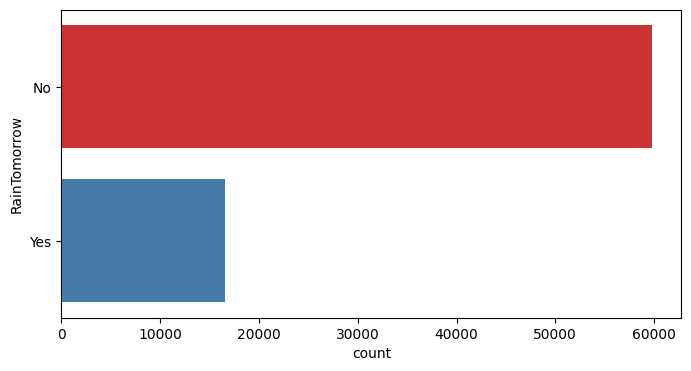

In [366]:
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.countplot(y="RainTomorrow", data=df_trabajo, palette="Set1")
plt.show()

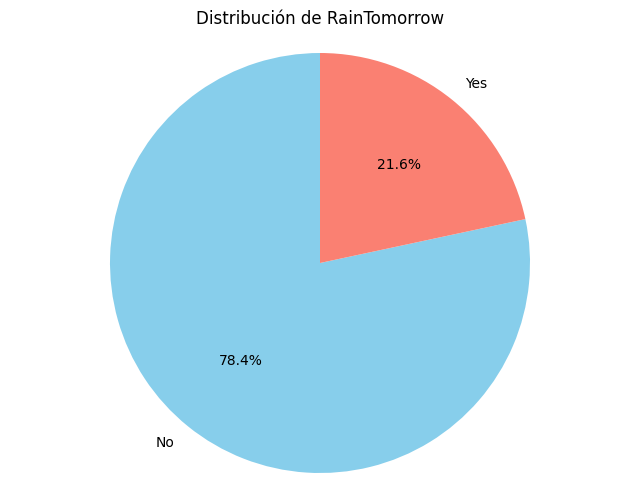

In [367]:
rain_counts = df_trabajo['RainTomorrow'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(rain_counts, labels=rain_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribución de RainTomorrow')
plt.axis('equal')  # Para que el gráfico sea un círculo perfecto
plt.show()

Vemos que "No" aparece en un 78.4% de las observaciones mientras que "Yes" aparece en un 21.6%. Esto nos indica un desbalanceo en los datos lo que se debe tener en cuenta a la hora de elegir las métricas para evaluar los resultados.

### Otras variables

Primero veamos la distribución de las variables numéricas

16it [00:46,  2.90s/it]


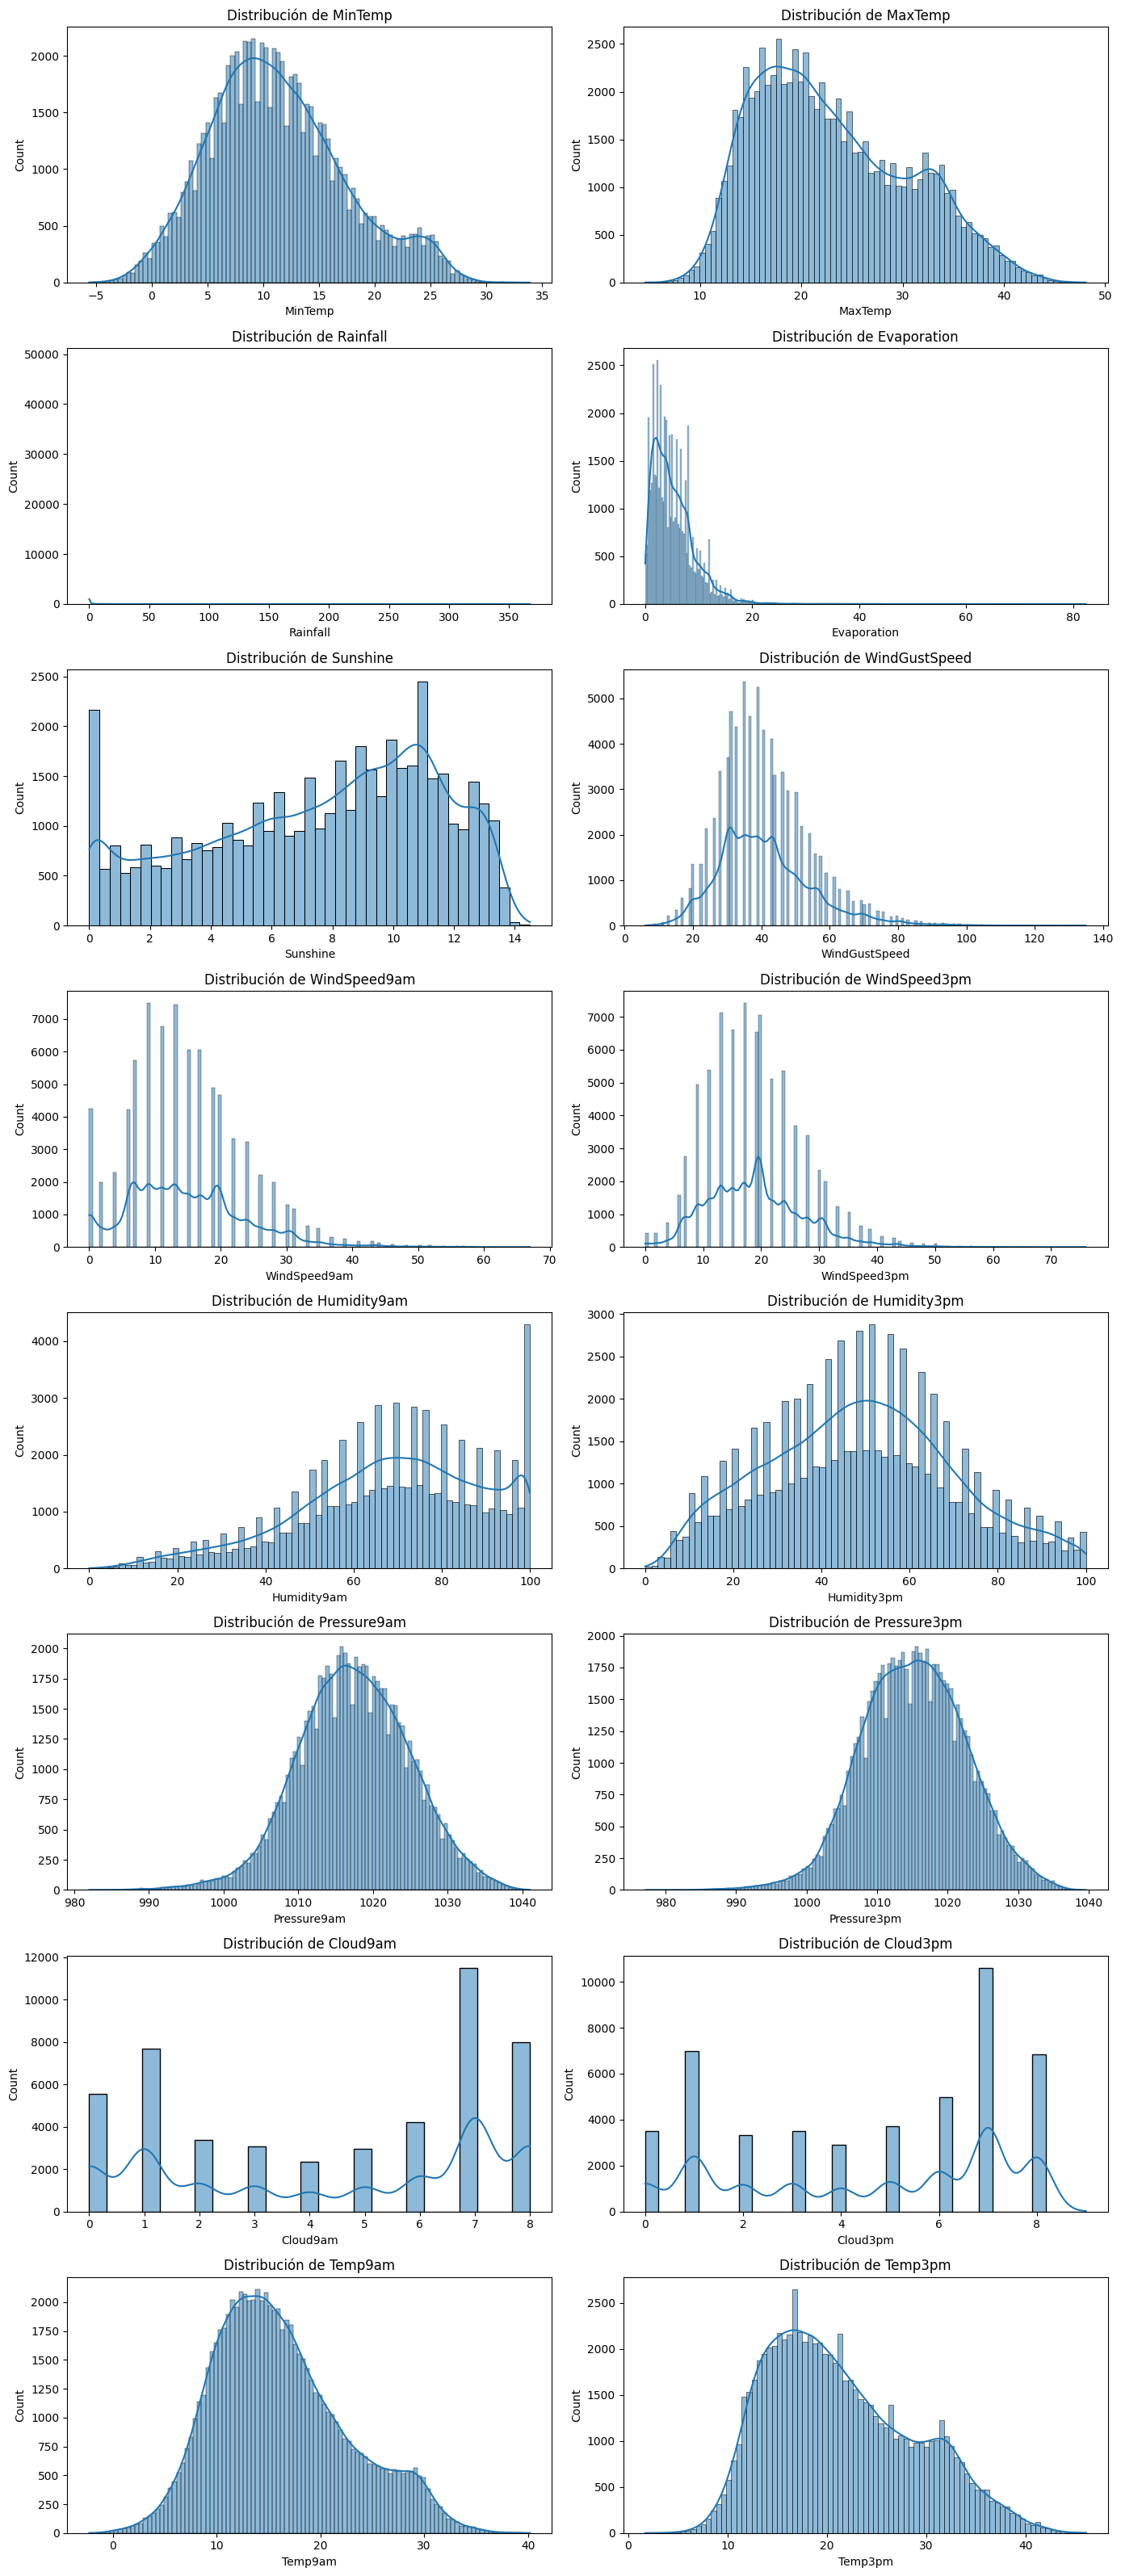

In [368]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import math

# Supongamos que 'df' es tu DataFrame y 'numerical_features' es una lista de nombres de columnas numéricas.
numerical_features = df_trabajo.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Determinar el número de filas necesarias para mostrar 2 gráficos por fila
n_rows = math.ceil(len(numerical_features) / 2)

# Crear una figura y ejes para los gráficos
fig, axes = plt.subplots(n_rows, 2, figsize=(14, n_rows * 4))

# Iterar a través de cada variable numérica
for i, col in tqdm(enumerate(numerical_features)):
    row = i // 2  # Determinar la fila
    col_pos = i % 2  # Determinar la columna
    sns.histplot(df_trabajo[col], ax=axes[row, col_pos], kde=True)
    axes[row, col_pos].set_title(f'Distribución de {col}')

# Eliminar los ejes vacíos si el número de gráficos es impar
if len(numerical_features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

# Ajustar el diseño
plt.tight_layout()
plt.show()

A partir de estos histogramas se pueden hacer las siguientes observaciones:

**Temperaturas (MinTemp, MaxTemp, Temp9am, Temp3pm):**

La temperatura sigue una distribución normal, lo que indica que la mayoría de los días presentan temperaturas cercanas al valor promedio, con pocas variaciones extremas.

**Precipitaciones (Rainfall):**

Se ve que la mayoría de los días presentan poca o ninguna precipitación.

**Velocidades del viento (WindGustSpeed, WindSpeed9am, WindSpeed3pm):**

Presentan distribuciones sesgadas a la derecha, lo que indica que no es común días de viento con altas velocidades.

**Humedad (Humidity9am, Humidity3pm):**

Hay una tendencia a una mayor humedad por las mañanas y menor humedad por las tardes.

**Presión atmosférica (Pressure9am, Pressure3pm):**

La presión atmosférica presenta también una distribución normal, es decir que la presión tiende a mantenerse en los mismos valores.

**Evaporación (Evaporation):**

Esta variable presentan distribuciones sesgada a la derecha, indicando que los días con mucha evaporación son menos frecuentes.

**Sol (Sunshine):**

Ligeramente sesgada a la izquierda, el sol se mantiene bastante uniforme. Podemos ver que hay cantidades similares de locaciones con poco o mucho sol.

En general, se puede decir que hay una diversidad de condiciones climáticas, con una prevalencia de condiciones moderadas pero con la presencia de eventos extremos en algunas variables como el viento y la lluvia.

### Datos faltantes

Analizamos datos faltantes

In [369]:
missing_values = df_trabajo.isnull().sum()
missing_percentage = (missing_values / len(df_trabajo)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data_filtered = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
missing_data_filtered

Missing Values  Percentage
Sunshine                31675   40.601687
Cloud3pm                31599   40.504268
Cloud9am                29344   37.613762
Evaporation             29310   37.570180
Pressure3pm              5044    6.465506
Pressure9am              5031    6.448843
WindDir9am               4627    5.930987
Humidity3pm              2118    2.714897
RainTomorrow             1722    2.207296
Rainfall                 1715    2.198323
RainToday                1715    2.198323
Temp3pm                  1472    1.886841
Humidity9am              1419    1.818904
WindGustDir              1292    1.656113
WindGustSpeed            1235    1.583049
Temp9am                   834    1.069039
MinTemp                   812    1.040839
WindDir3pm                804    1.030584
MaxTemp                   756    0.969057
WindSpeed9am              353    0.452483
WindSpeed3pm              352    0.451201

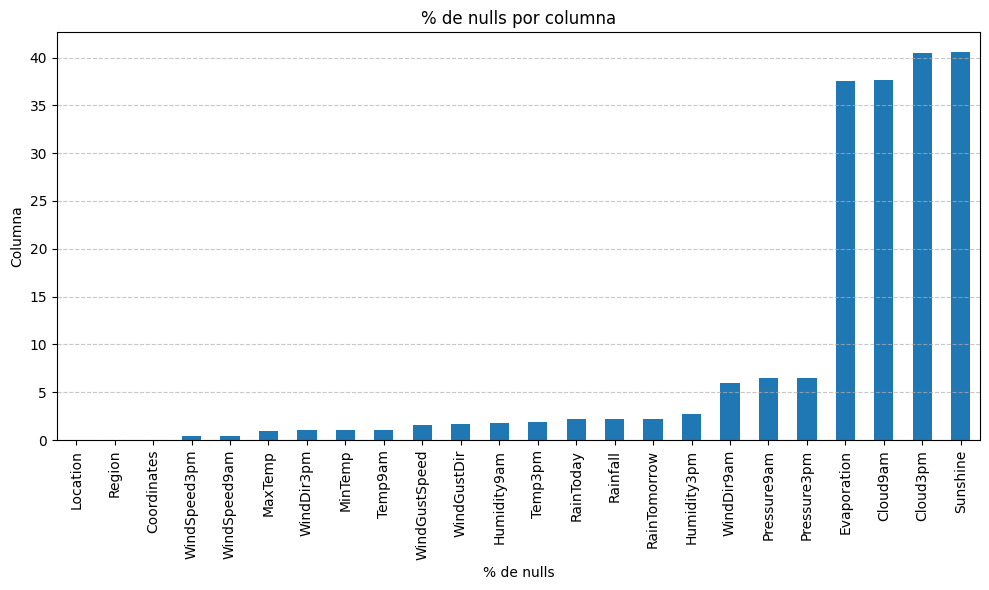

In [370]:
df_to_graph = ((df_trabajo.isnull().sum() / len(df_trabajo)) * 100).sort_values()

plotear_grafico(df_to_graph, "% de nulls por columna", "% de nulls", "Columna")

Vemos que hay un porcentaje alto de datos faltantes principalmente en cuatro columnas numéricas: Sunshine, Cloud3pm, Cloud9am y Evaporation. El porcentaje no es lo suficientemente alto para considerar eliminar esas columnas por completo por lo que recurriremos a la imputación de datos para que esta falta de datos no afecte en nuestra predicción.

### Datos atípicos

Analizamos datos atípicos

In [371]:
def detectar_outliers_iqr(df):
    outliers_indices = {}

    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for column in numeric_df.columns:
        outliers = df[(df[column] < lower_bound[column]) | (df[column] > upper_bound[column])].index
        outliers_indices[column] = outliers

    return outliers_indices

outliers_iqr = detectar_outliers_iqr(df_trabajo)

# Crear una lista de tuplas con el nombre de la columna, el número de outliers y el porcentaje
outlier_counts = []
total_rows = df_trabajo.shape[0]  # Total de filas en el DataFrame

for column, outliers in outliers_iqr.items():
    count = len(outliers)
    percentage = (count / total_rows) * 100  # Calcular el porcentaje de outliers
    outlier_counts.append((column, count, percentage))

# Ordenar la lista por el número de outliers en orden descendente
outlier_counts.sort(key=lambda x: x[1], reverse=True)

# Imprimir los resultados en orden
for column, count, percentage in outlier_counts:
    print(f"{column}: {count} outliers ({percentage:.2f}%)")



Rainfall: 14853 outliers (19.04%)
WindGustSpeed: 1889 outliers (2.42%)
WindSpeed9am: 1324 outliers (1.70%)
Evaporation: 1292 outliers (1.66%)
WindSpeed3pm: 1229 outliers (1.58%)
Pressure9am: 624 outliers (0.80%)
Pressure3pm: 455 outliers (0.58%)
Humidity9am: 430 outliers (0.55%)
Temp9am: 423 outliers (0.54%)
MinTemp: 380 outliers (0.49%)
Temp3pm: 58 outliers (0.07%)
MaxTemp: 17 outliers (0.02%)
Sunshine: 0 outliers (0.00%)
Humidity3pm: 0 outliers (0.00%)
Cloud9am: 0 outliers (0.00%)
Cloud3pm: 0 outliers (0.00%)


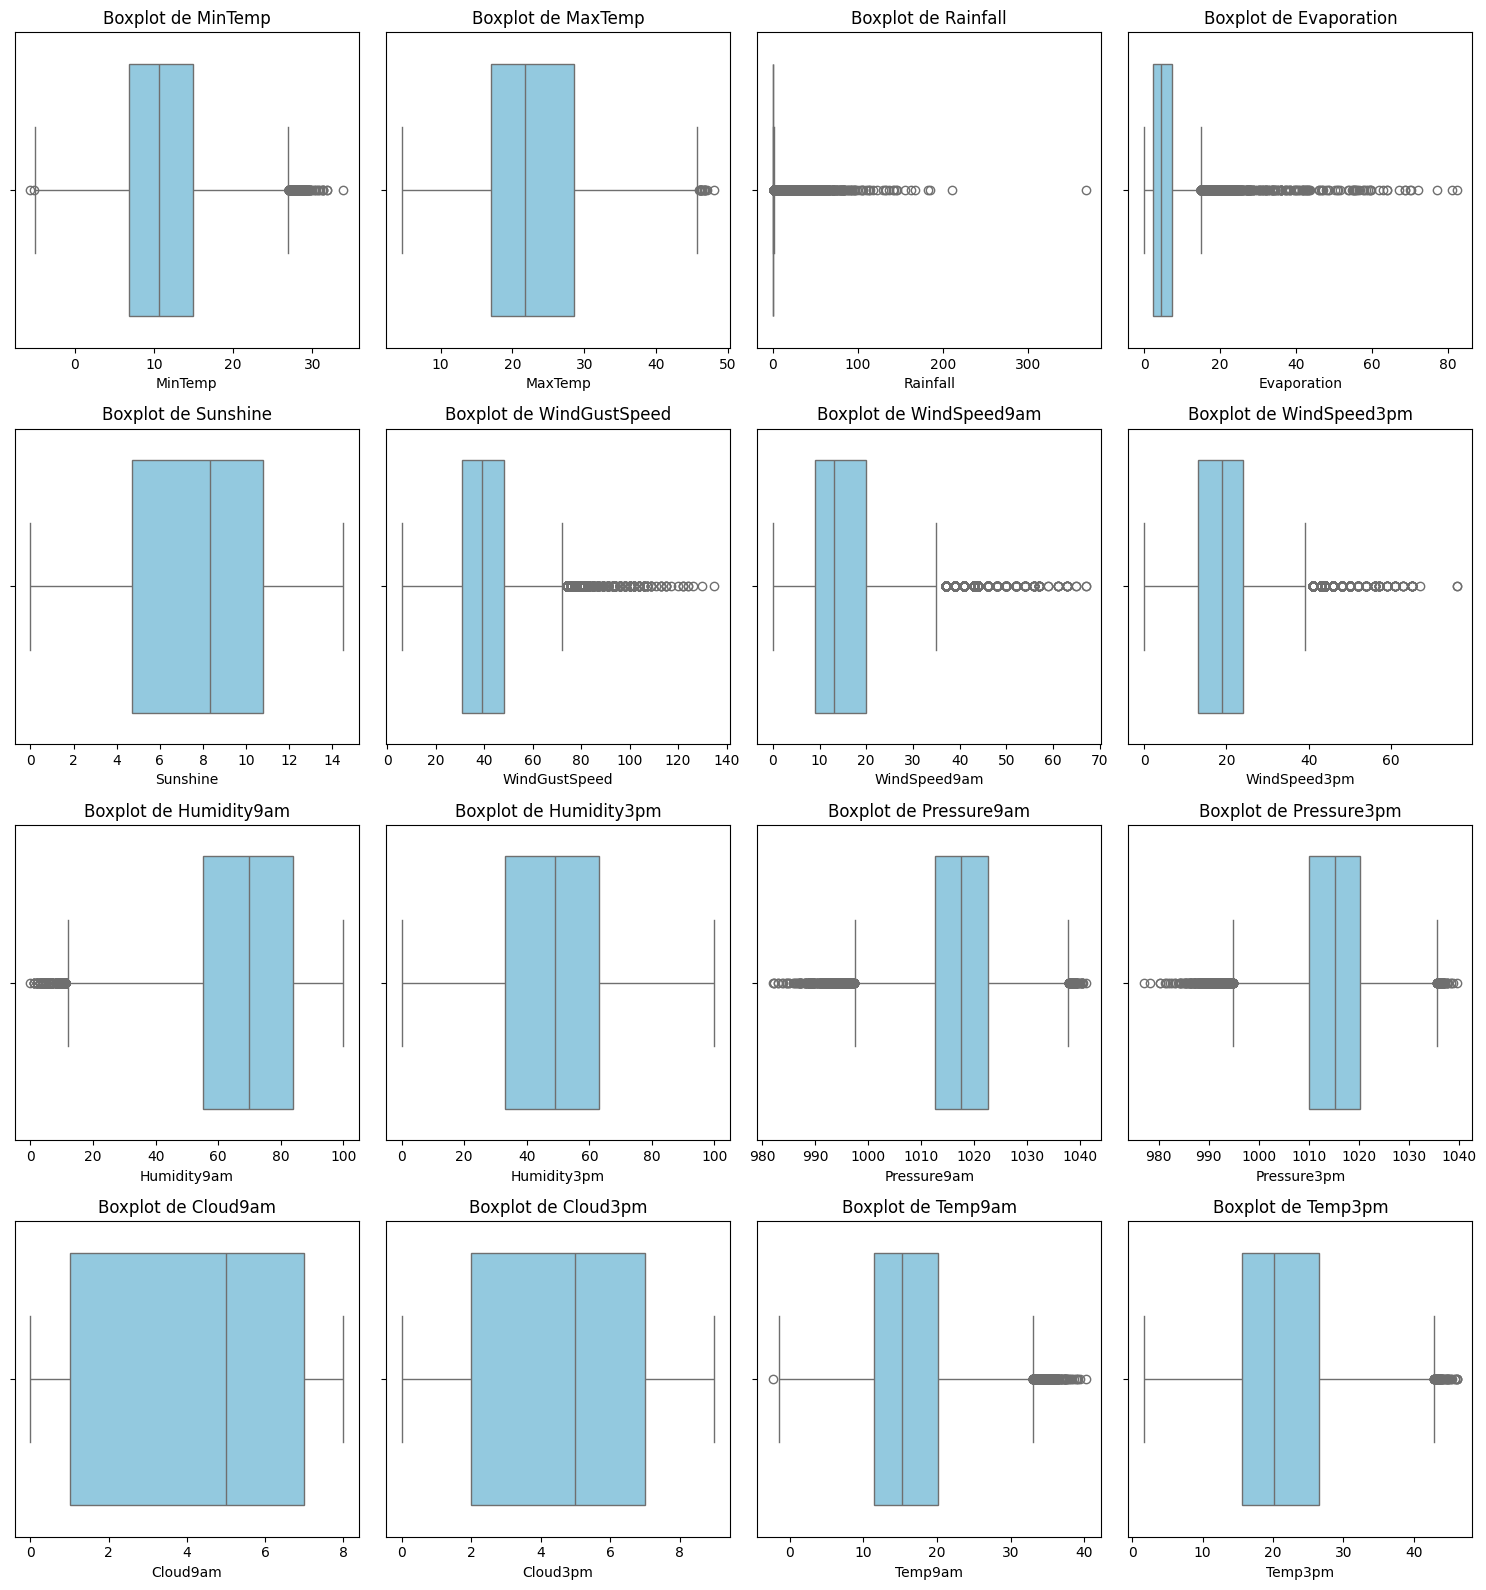

In [372]:
graficar_boxplots(df_trabajo)

Principalmente notamos que rainfall tiene una cantidad considerable de outliers que se deben tratar. Otras variables como WindGustSpeed, Evaporation,WindSpeed9am, WindSpeed3pm poseen outliers pero en menor cantidad. Cabe destacar la presencia de valores muy extremos y alejados al resto de las observaciones en rainfall, Evaporation y WindSpeed3pm. Esto puede tratarse de un error al cargar los datos o un evento climático extraordinario.

## Análisis Multivariado

Primero creamos un heatmap para ver si existen correlaciones entre las variables numéricas.

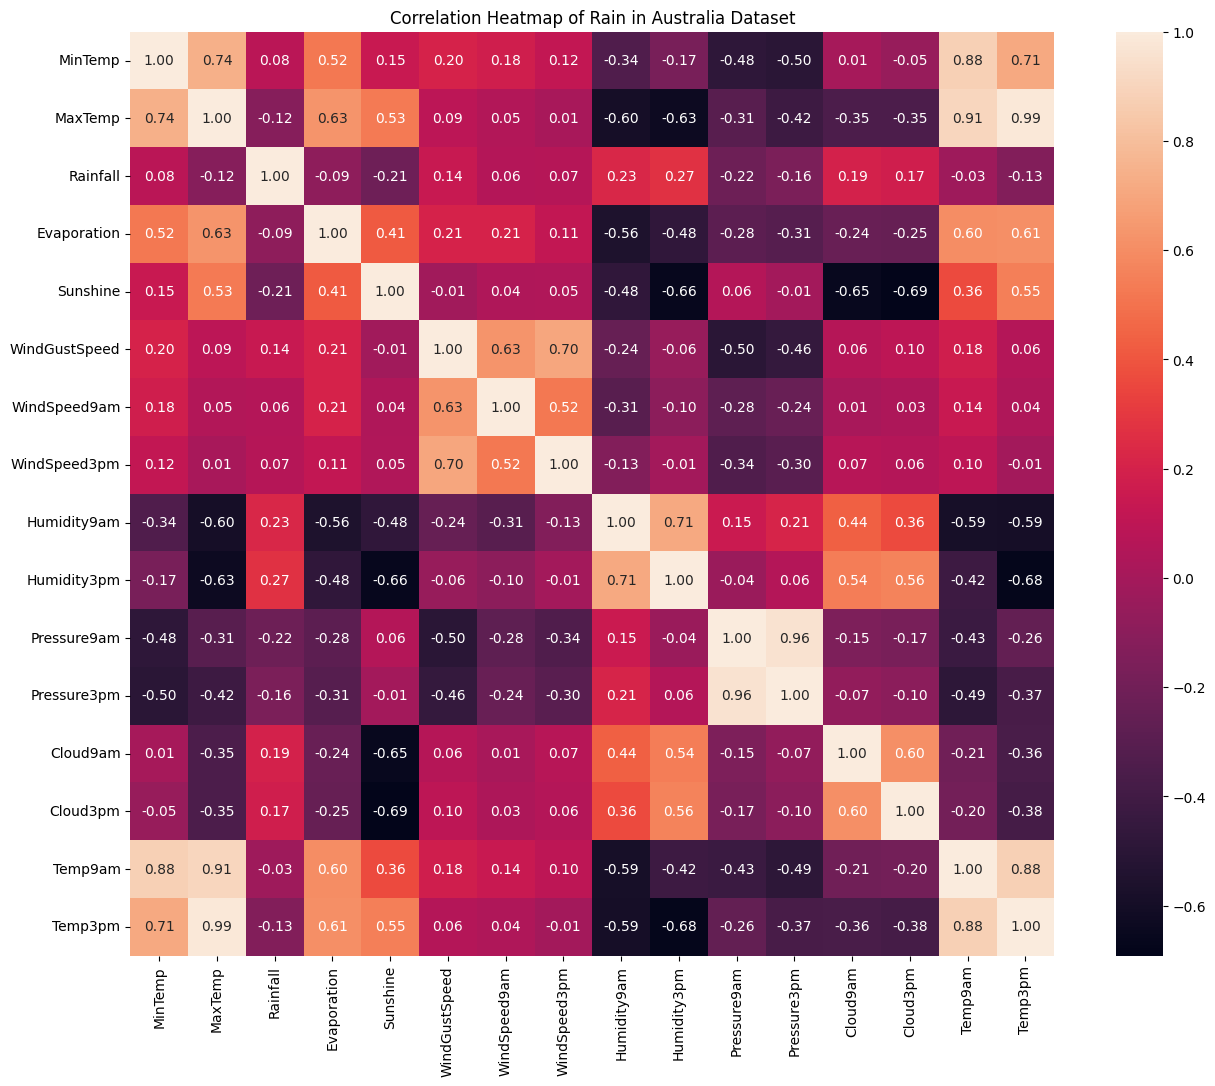

In [373]:
df_numeric = df_trabajo.select_dtypes(include=['int64', 'float64'])
correlation = df_numeric.corr()

plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


Noto que hay mucha correlacion entre las temperaturas más que nada. Con una correlación de casi 1 entre Temp3pm y MaxTemp se puede considerar deshacerse de alguna de estas columnas.

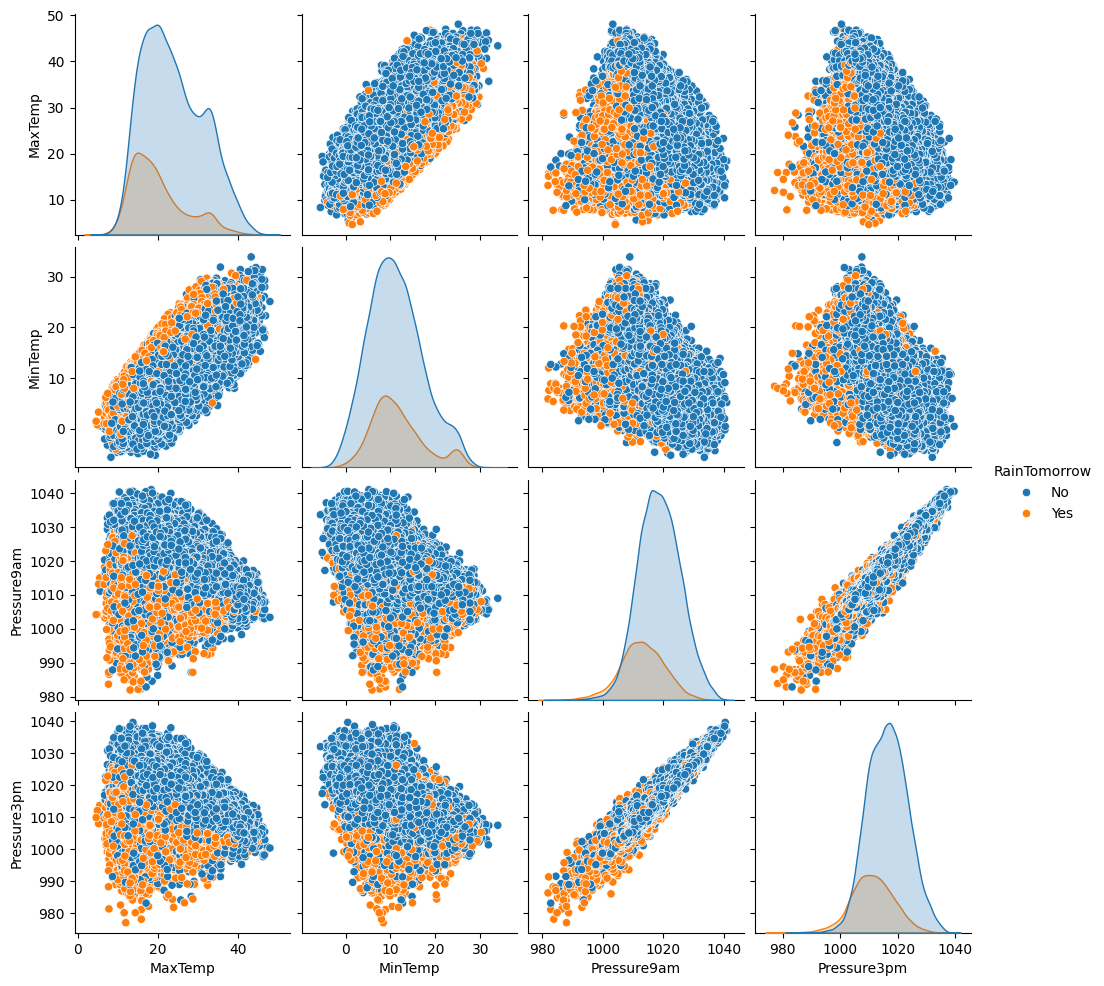

In [374]:
sns.pairplot(data=df_trabajo, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm'), hue='RainTomorrow')
plt.show()

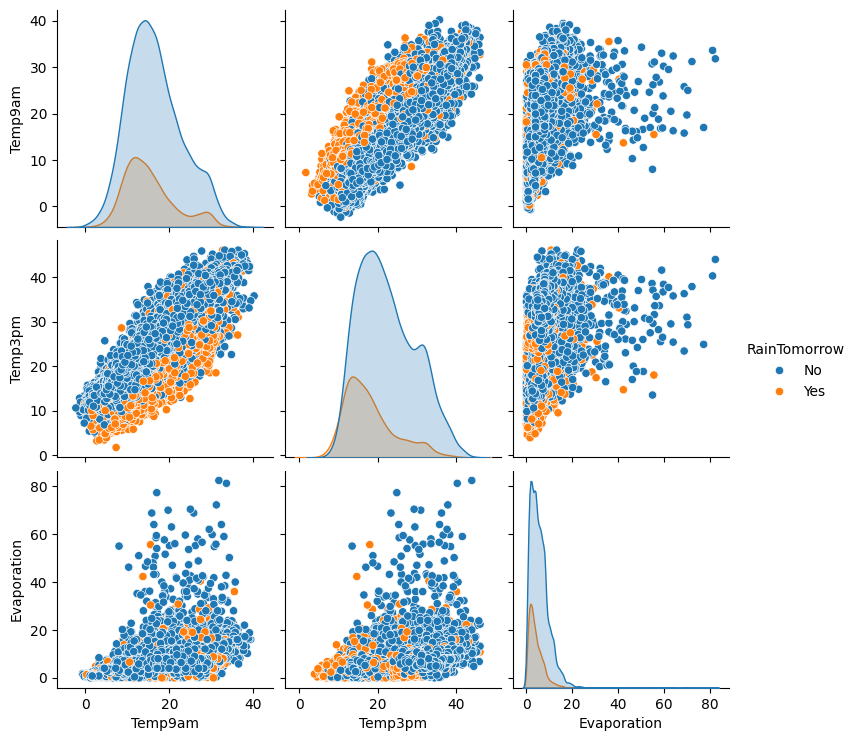

In [375]:
sns.pairplot(data=df_trabajo, vars=('Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow')
plt.show()

## Separación en train-test

Declaro vector de características y variable target

In [376]:
df_x = df_trabajo.drop(['RainTomorrow'], axis=1)

df_y = df_trabajo['RainTomorrow']

In [377]:
df_y

27167      No
27168      No
27169      No
27170      No
27171      No
         ... 
145455     No
145456     No
145457     No
145458     No
145459    NaN
Name: RainTomorrow, Length: 78014, dtype: object

Separo en training y test set

In [378]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 2)

Chequeo tamaño de los sets

In [379]:
x_train.shape, x_test.shape

((62411, 23), (15603, 23))

## Ingeniería de características

### Tratamiento de datos faltantes

Cantidad y porcentaje de datos faltantes en cada columna del train set

In [380]:
missing_values = x_train.isnull().sum()
missing_percentage = (missing_values / len(x_train)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data_filtered = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
missing_data_filtered

Missing Values  Percentage
Sunshine                25294   40.528112
Cloud3pm                25234   40.431975
Evaporation             23461   37.591130
Cloud9am                23420   37.525436
Pressure3pm              4008    6.421945
Pressure9am              3998    6.405922
WindDir9am               3696    5.922033
Humidity3pm              1735    2.779959
RainToday                1395    2.235183
Rainfall                 1395    2.235183
Temp3pm                  1219    1.953181
Humidity9am              1176    1.884283
WindGustDir              1059    1.696816
WindGustSpeed            1017    1.629520
Temp9am                   696    1.115188
MinTemp                   675    1.081540
WindDir3pm                640    1.025460
MaxTemp                   628    1.006233
WindSpeed9am              287    0.459855
WindSpeed3pm              284    0.455048

Cantidad y porcentaje de datos faltantes en cada columna del test set

In [381]:
missing_values = x_test.isnull().sum()
missing_percentage = (missing_values / len(x_test)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data_filtered = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
missing_data_filtered

Missing Values  Percentage
Sunshine                 6381   40.895982
Cloud3pm                 6365   40.793437
Cloud9am                 5924   37.967058
Evaporation              5849   37.486381
Pressure3pm              1036    6.639749
Pressure9am              1033    6.620522
WindDir9am                931    5.966801
Humidity3pm               383    2.454656
RainToday                 320    2.050888
Rainfall                  320    2.050888
Temp3pm                   253    1.621483
Humidity9am               243    1.557393
WindGustDir               233    1.493303
WindGustSpeed             218    1.397167
WindDir3pm                164    1.051080
Temp9am                   138    0.884445
MinTemp                   137    0.878036
MaxTemp                   128    0.820355
WindSpeed3pm               68    0.435814
WindSpeed9am               66    0.422996

Asumo que los datos faltantes se encuentran completamente al azar. Utilizaremos la mediana para completar los valores faltantes de las variables numéricas porque minimiza el impacto de valores atípicos y mantiene la representatividad de los datos.

Las medidas estadísticas que se usarán para rellenar los valores faltantes tanto en el conjunto de entrenamiento como en el de prueba deben extraerse únicamente del conjunto de entrenamiento. Esto es para evitar el overfitting.

In [382]:
numerical = [col for col in x_train.columns if x_train[col].dtype in ['int64', 'float64']]

for df1 in [x_train, x_test]:
    for col in numerical:
        col_median = x_train[col].median()
        df1[col].fillna(col_median, inplace=True)

In [383]:
categorical = [col for col in x_train.columns if x_train[col].dtype == 'object']

for df2 in [x_train, x_test]:
    for var in categorical:
        df2[var].fillna(x_train[var].mode()[0], inplace=True)

In [384]:
y_train.fillna(y_train.mode()[0], inplace=True)
y_test.fillna(y_train.mode()[0], inplace=True)

En este punto nuestro dataframe de train y test no cuentan ya con datos faltantes.

In [385]:
print(f"Cantidad total de valores nulos en el dataset de entrenamiento: {x_train.isna().sum().sum()}")
print(f"El dataFrame tiene {x_train.shape[0]} filas y {x_train.shape[1]} columnas.")

Cantidad total de valores nulos en el dataset de entrenamiento: 0
El dataFrame tiene 62411 filas y 23 columnas.


In [386]:
print(f"Cantidad total de valores nulos en el dataset de testeo: {x_test.isna().sum().sum()}")
print(f"El dataFrame tiene {x_test.shape[0]} filas y {x_train.shape[1]} columnas.")

Cantidad total de valores nulos en el dataset de testeo: 0
El dataFrame tiene 15603 filas y 23 columnas.


In [387]:
print("Valores nulos en y_train:", y_train.isnull().sum())
print("Valores nulos en y_test:", y_test.isnull().sum())


Valores nulos en y_train: 0
Valores nulos en y_test: 0


In [388]:
x_train.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
28966           Richmond     18.4     25.7       2.6          1.2       8.3   
108555           Woomera      4.8     16.1       0.0          2.5       8.3   
113332       Witchcliffe     15.1     29.8       0.0          4.4       8.3   
64540   MelbourneAirport     16.1     37.9       0.0         10.8      12.1   
142601         Katherine     25.2     37.5       0.0          8.0       8.3   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
28966           NE           24.0          N        NNE  ...         64.0   
108555          SE           26.0         SE        SSE  ...         42.0   
113332          SE           39.0         SE         SE  ...         51.0   
64540            N           59.0          N         NW  ...         10.0   
142601          NW           31.0         NE        ESE  ...        100.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
28966        1026.5       1023.3       5.0       5.0     19.8     24.2   
108555       1033.6       1030.8       0.0       5.0      9.3     15.7   
113332       1012.4       1009.8       5.0       5.0     22.4     28.2   
64540        1013.1       1009.9       5.0       5.0     29.1     37.1   
142601       1009.3       1005.3       2.0       6.0     30.3     35.0   

        RainToday                Region            Coordinates  
28966         Yes              Victoria   (-33.6000, 150.7760)  
108555         No  Australia Meridional   (-31.1989, 136.8255)  
113332         No  Australia Occidental   (-34.0150, 115.1000)  
64540          No              Victoria   (-37.6690, 144.8410)  
142601         No  Territorio del Norte   (-14.4650, 132.2635)  

[5 rows x 23 columns]

### Tratamiento de datos atípicos

Habíamos visto que la mayoría de las variables presentan outliers bastante cercanos a nuestro rango establecido. Sin embargo, algunos datos atípicos se alejan mucho y deben ser tratados. Particularmente en rainfall. Para ello, vamos a limitarlos usando la función cap_data.

In [389]:
import pandas as pd
import numpy as np

def cap_data(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

columns_to_cap = [
    'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
    'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm'
]

for df in [x_train, x_test]:
    for col in columns_to_cap:
        df = cap_data(df, col)

x_train.to_csv("x_train_ajustado.csv", index=False)
x_test.to_csv("x_test_ajustado.csv", index=False)
x_train_ajustado = x_train.copy()
x_test_ajustado = x_test.copy()

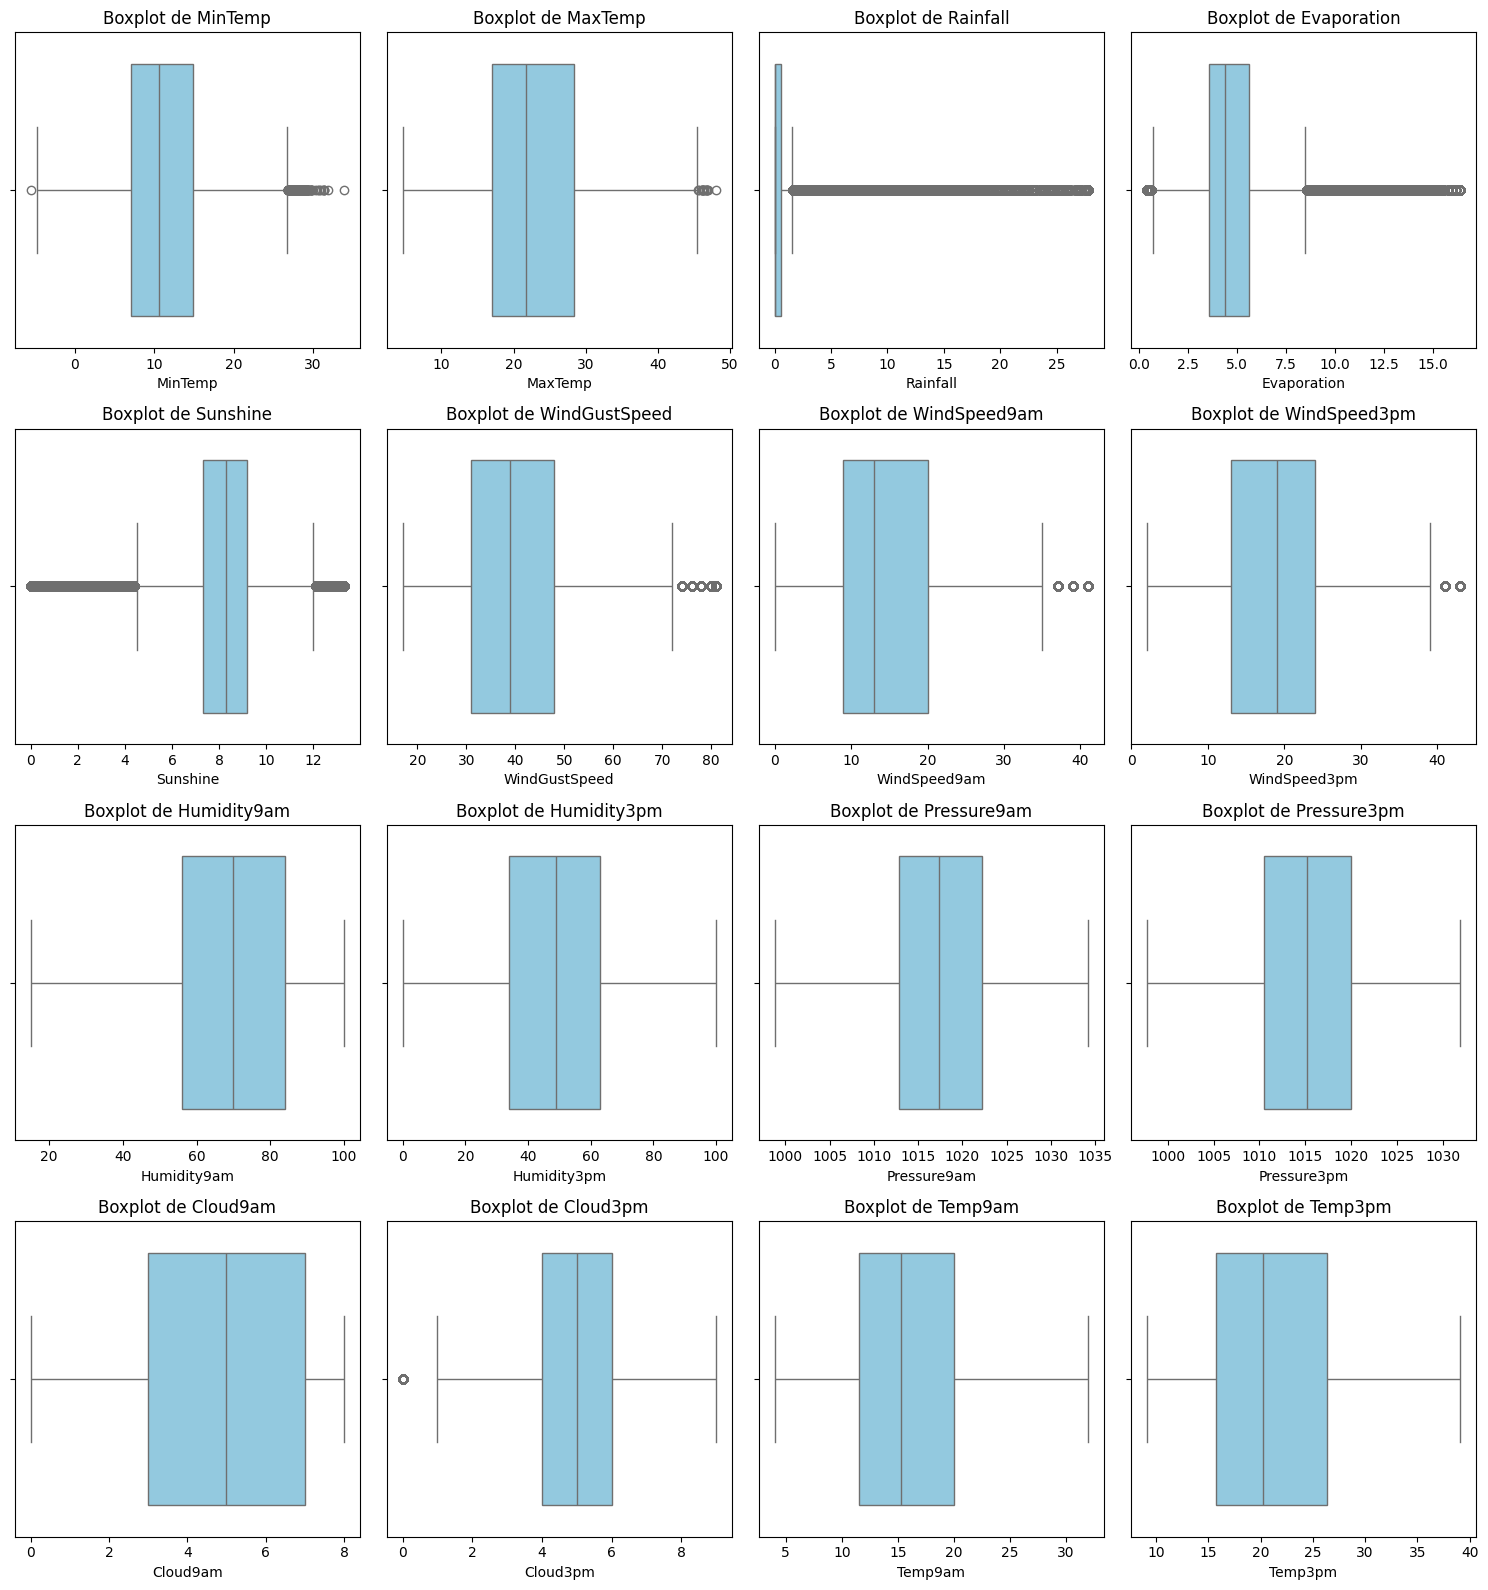

In [390]:

graficar_boxplots(x_train_ajustado)

Vemos que los outliers se encuentran mucho más cerca del rango establecido así que podemos usarlos.

### Transformación de datos

Exploro variables categóricas

In [391]:
categorical = x_train.select_dtypes(include=['object']).columns
x_train[categorical].head()

Location WindGustDir WindDir9am WindDir3pm RainToday  \
28966           Richmond          NE          N        NNE       Yes   
108555           Woomera          SE         SE        SSE        No   
113332       Witchcliffe          SE         SE         SE        No   
64540   MelbourneAirport           N          N         NW        No   
142601         Katherine          NW         NE        ESE        No   

                      Region            Coordinates  
28966               Victoria   (-33.6000, 150.7760)  
108555  Australia Meridional   (-31.1989, 136.8255)  
113332  Australia Occidental   (-34.0150, 115.1000)  
64540               Victoria   (-37.6690, 144.8410)  
142601  Territorio del Norte   (-14.4650, 132.2635)

In [392]:
for variable in categorical:
    print(variable, ' contains ', len(df_trabajo[variable].unique()), ' labels')

Location  contains  27  labels
WindGustDir  contains  17  labels
WindDir9am  contains  17  labels
WindDir3pm  contains  17  labels
RainToday  contains  3  labels
Region  contains  5  labels
Coordinates  contains  27  labels


Veo que *RainToday* es binaria. A continuación convierto las variables categóricas en variables numéricas.

In [393]:
binary_map = {'Yes': 1, 'No': 0}
x_train['RainToday'] = x_train['RainToday'].map(binary_map)
print(x_train['RainToday'].unique())

[1 0]


In [394]:
y_train = y_train.map(binary_map)

In [395]:
coord_col = ['Coordinates']
x_train[['Latitude', 'Longitude']] = x_train['Coordinates'].str.extract(r'\((-?\d+\.\d+),\s*(-?\d+\.\d+)\)')
x_train['Latitude'] = x_train['Latitude'].astype(float)
x_train['Longitude'] = x_train['Longitude'].astype(float)
print(x_train['Latitude'].head())

28966    -33.6000
108555   -31.1989
113332   -34.0150
64540    -37.6690
142601   -14.4650
Name: Latitude, dtype: float64


In [396]:
x_test['RainToday'] = x_test['RainToday'].map(binary_map)
print(x_test['RainToday'].unique())

[0 1]


In [397]:
y_test = y_test.map(binary_map)

In [398]:
x_test[['Latitude', 'Longitude']] = x_test['Coordinates'].str.extract(r'\((-?\d+\.\d+),\s*(-?\d+\.\d+)\)')
x_test['Latitude'] = x_test['Latitude'].astype(float)
x_test['Longitude'] = x_test['Longitude'].astype(float)
print(x_test['Latitude'].head())

131635   -42.8821
83338    -38.0806
143502   -14.4650
143001   -14.4650
63281    -38.1065
Name: Latitude, dtype: float64


In [399]:
x_train = x_train.reset_index(drop=True)
numerical = [col for col in x_train.columns if x_train[col].dtypes in ['int64', 'float64']]

x_train_transformado = pd.concat([
    x_train[numerical],
    pd.get_dummies(x_train['Location'], drop_first=True, dtype=int),
    pd.get_dummies(x_train['WindGustDir'], drop_first=True, dtype=int),
    pd.get_dummies(x_train['WindDir9am'], drop_first=True, dtype=int),
    pd.get_dummies(x_train['WindDir3pm'], drop_first=True, dtype=int)
], axis=1)

x_test_transformado = pd.concat([
    x_test[numerical],
    pd.get_dummies(x_test['Location'], drop_first=True, dtype=int),
    pd.get_dummies(x_test['WindGustDir'], drop_first=True, dtype=int),
    pd.get_dummies(x_test['WindDir9am'], drop_first=True, dtype=int),
    pd.get_dummies(x_test['WindDir3pm'], drop_first=True, dtype=int)
], axis=1)

x_train_final = x_train_transformado.copy()
x_test_final = x_test_transformado.copy()

x_train_final.to_csv('x_train_transformado.csv', index=False)
x_test_final.to_csv('x_test_transformado.csv', index=False)
y_train.to_csv('y_train_transformado.csv', index=False)
y_test.to_csv('y_test_transformado.csv', index=False)

Verificamos que no se hayan agregado nuevas filas

In [400]:
x_train_final.shape

(62411, 90)

In [401]:
x_test_final.shape

(15603, 90)

En este punto todas nuestras variables deben ser numéricas.

In [402]:
categorical = x_train_final.select_dtypes(include=['object']).columns
print("Variables categóricas restantes en el dataset:")
print(categorical)

Variables categóricas restantes en el dataset:
Index([], dtype='object')


In [403]:
numerical = x_train_final.select_dtypes(include=['int64', 'float64']).columns
print("Variables numéricas en el dataset:")
print(numerical)

Variables numéricas en el dataset:
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Latitude', 'Longitude',
       'AliceSprings', 'Ballarat', 'Bendigo', 'Dartmoor', 'Darwin', 'Hobart',
       'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport', 'Mildura',
       'MountGambier', 'Nhil', 'Nuriootpa', 'PearceRAAF', 'Perth',
       'PerthAirport', 'Portland', 'Richmond', 'Sale', 'SalmonGums', 'Uluru',
       'Walpole', 'Watsonia', 'Witchcliffe', 'Woomera', 'ENE', 'ESE', 'N',
       'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW',
       'WSW', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW',
       'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'],
      dtype=

In [404]:
x_train_final.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     18.4     25.7       2.6          1.2       8.3           24.0   
1      4.8     16.1       0.0          2.5       8.3           26.0   
2     15.1     29.8       0.0          4.4       8.3           39.0   
3     16.1     37.9       0.0         10.8      12.1           59.0   
4     25.2     37.5       0.0          8.0       8.3           31.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  NNW  NW  S  SE  \
0           0.0           2.0        100.0         64.0  ...    0   0  0   0   
1           9.0           9.0         71.0         42.0  ...    0   0  0   0   
2          26.0          17.0         56.0         51.0  ...    0   0  0   1   
3          37.0          35.0         17.0         10.0  ...    0   1  0   0   
4           9.0           9.0         64.0        100.0  ...    0   0  0   0   

   SSE  SSW  SW  W  WNW  WSW  
0    0    0   0  0    0    0  
1    1    0   0  0    0    0  
2    0    0   0  0    0    0  
3    0    0   0  0    0    0  
4    0    0   0  0    0    0  

[5 rows x 90 columns]

In [405]:
x_test_final.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
131635      7.8     19.7       0.2          1.8       3.1           56.0   
83338       3.2     15.5       0.0          1.8       5.2           43.0   
143502     19.2     32.7       0.0          5.8       8.3           41.0   
143001     22.4     34.0      11.2          7.0       8.3           39.0   
63281      11.6     31.1       0.0          4.4       8.3           81.0   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  NNW  NW  S  \
131635          11.0          22.0         72.0         52.0  ...    0   1  0   
83338            4.0          20.0         70.0         49.0  ...    0   0  0   
143502          20.0          24.0         42.0         49.0  ...    0   0  0   
143001           4.0           7.0         91.0         63.0  ...    0   0  0   
63281           17.0          28.0         49.0         23.0  ...    0   0  0   

        SE  SSE  SSW  SW  W  WNW  WSW  
131635   0    0    0   0  0    0    0  
83338    0    0    1   0  0    0    0  
143502   0    0    0   0  0    0    0  
143001   0    0    0   0  0    1    0  
63281    0    0    0   0  0    1    0  

[5 rows x 90 columns]

### Escalado de datos

Vamos a normalizar nuestros datos para que se ajusten a una misma escala.

In [406]:
scaler = MinMaxScaler()

x_train_normalizado = pd.DataFrame(scaler.fit_transform(x_train_final), columns=x_train_final.columns)
x_test_normalizado = pd.DataFrame(scaler.transform(x_test_final), columns=x_test_final.columns)
x_train_normalizado.to_csv('x_train_normalizado.csv', index=False)
x_test_normalizado.to_csv('x_test_normalizado.csv', index=False)
x_train_normalizado.describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  62411.000000  62411.000000  62411.000000  62411.000000  62411.000000   
mean       0.426244      0.423026      0.059612      0.283641      0.593142   
std        0.152804      0.172893      0.162046      0.185115      0.222819   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.318987      0.285057      0.000000      0.200000      0.548872   
50%        0.410127      0.393103      0.000000      0.250000      0.624060   
75%        0.518987      0.547126      0.021583      0.325000      0.691729   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   62411.000000  62411.000000  62411.000000  62411.000000  62411.000000   
mean        0.371265      0.355126      0.410021      0.627436      0.488336   
std         0.203722      0.210039      0.197777      0.240307      0.208781   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.218750      0.219512      0.268293      0.482353      0.340000   
50%         0.343750      0.317073      0.414634      0.647059      0.490000   
75%         0.484375      0.487805      0.536585      0.811765      0.630000   
max         1.000000      1.000000      1.000000      1.000000      1.000000   

       ...           NNW            NW             S            SE  \
count  ...  62411.000000  62411.000000  62411.000000  62411.000000   
mean   ...      0.069571      0.065437      0.077166      0.063835   
std    ...      0.254425      0.247298      0.266857      0.244461   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

                SSE           SSW            SW             W           WNW  \
count  62411.000000  62411.000000  62411.000000  62411.000000  62411.000000   
mean       0.069203      0.070212      0.094647      0.077486      0.061143   
std        0.253800      0.255506      0.292729      0.267364      0.239594   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                WSW  
count  62411.000000  
mean       0.080963  
std        0.272781  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 90 columns]

# Modelos

Nos preparamos para la validación cruzada usando 5 folds.

In [407]:
cv = StratifiedKFold(n_splits = 5, shuffle = True)

## Árbol de decisión

Exactitud (Accuracy):  0.84900339678267
Precisión (Precision):  0.8386025054801133
Sensibilidad (Recall):  0.84900339678267
Puntuación F1:  0.839582066711853
AUC(ROC):  0.7234404819450106

Informe de Clasificación: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12295
           1       0.70      0.51      0.59      3308

    accuracy                           0.85     15603
   macro avg       0.79      0.72      0.75     15603
weighted avg       0.84      0.85      0.84     15603



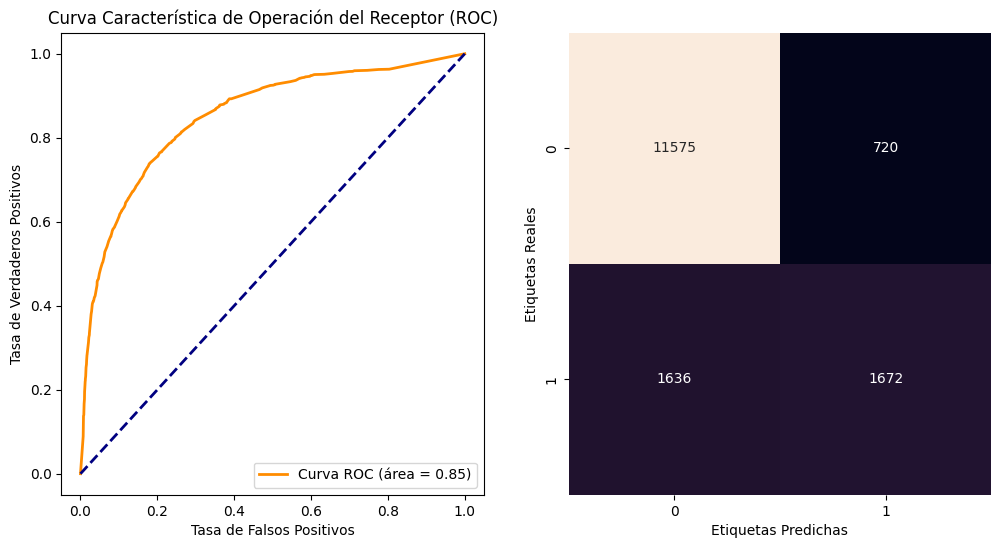

--- Métricas del Conjunto de Entrenamiento ---
Exactitud (Accuracy):  0.8762397654259666
Precisión (Precision):  0.8700476376648284
Sensibilidad (Recall):  0.8762397654259666
Puntuación F1:  0.868638598686873
AUC(ROC):  0.7645796079260636

Informe de Clasificación para el Conjunto de Entrenamiento: 
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     49204
           1       0.79      0.57      0.66     13207

    accuracy                           0.88     62411
   macro avg       0.84      0.76      0.79     62411
weighted avg       0.87      0.88      0.87     62411



In [409]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


model_dt = DecisionTreeClassifier()


model_dt, acc_dt_test, pr_dt_test, rec_dt_test, f1_dt_test, roc_auc_dt_test, param_dt = entrenar_modelo_con_busqueda_aleatoria_test(model_dt, dt_param_grid,
                                                                    x_train_normalizado, y_train, x_test_normalizado, y_test, cv)

model_dt, acc_dt_train, pr_dt_train, rec_dt_train, f1_dt_train, roc_auc_dt_train, param_dt= entrenar_modelo_con_busqueda_aleatoria_train(model_dt, dt_param_grid,
                                                                    x_train_normalizado, y_train, cv)



Podemos ver los mejores hiperparametros elegidos, seguido por un grafico representativo del árbol

In [410]:
print(param_dt)

{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'}


In [411]:
best_model_dt = model_dt.fit(x_train_normalizado, y_train)

plt.figure(figsize=(100, 100))

tree_plot_completo = plot_tree(
    best_model_dt,
    feature_names=x_train_normalizado.columns.to_list(),
    max_depth=2,
    filled=True,
    rounded=True,
    class_names=["No", "Yes"]
)

plt.show()

Vemos que el nodo raíz es Humidity3pm. Si la humedad es mayor a 0.685, el árbol sigue por una rama indicando una mayor probabilidad de lluvia.
Si la humedad es menor o igual a 0.685, se sigue por otra rama indicando una menor probabilidad de lluvia.
Así se llega a los nodos intermedios. Después de dividir los datos con base en la humedad, el árbol buscará una segunda variable que pueda dividir aún más esos subconjuntos. En este caso Pressure9am y Pressure3pm. Hace esto sucesivamente hasta llegar a los nodos hoja donde se toma una decisión final. En los nodos hoja, el árbol ya no divide más los datos, sino que asigna una clase final (en este caso, "Yes" o "No").
Tambien se puede apreciar que predomina la clase "No", ya que es la que posee una mayor cantidad de muestras en comparación al "Yes", haciendo referencia a nuestra variable target.

## Random Forest

Exactitud (Accuracy):  0.8707299878228546
Precisión (Precision):  0.8641000827642955
Sensibilidad (Recall):  0.8707299878228546
Puntuación F1:  0.8610582517658393
AUC(ROC):  0.7479433077316848

Informe de Clasificación: 
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     12295
           1       0.79      0.53      0.64      3308

    accuracy                           0.87     15603
   macro avg       0.84      0.75      0.78     15603
weighted avg       0.86      0.87      0.86     15603



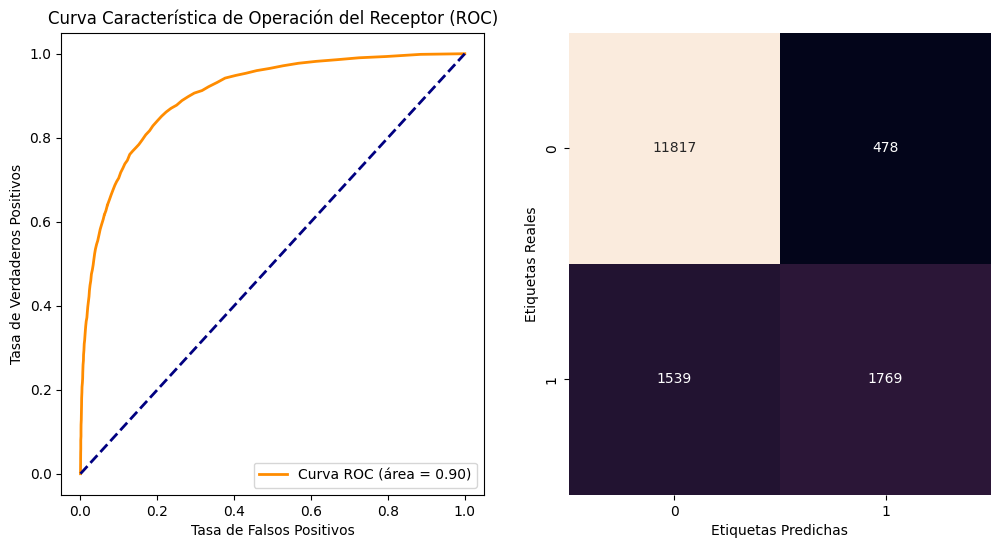

--- Métricas del Conjunto de Entrenamiento ---
Exactitud (Accuracy):  0.9735463299738828
Precisión (Precision):  0.9741043010992516
Sensibilidad (Recall):  0.9735463299738828
Puntuación F1:  0.9729576368082146
AUC(ROC):  0.9398772041419579

Informe de Clasificación para el Conjunto de Entrenamiento: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     49204
           1       0.99      0.88      0.93     13207

    accuracy                           0.97     62411
   macro avg       0.98      0.94      0.96     62411
weighted avg       0.97      0.97      0.97     62411



In [412]:
rf_param_grid = {
    'n_estimators': [100, 150],
    'criterion': ['gini'],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

model_rf = RandomForestClassifier()

model_rf, acc_rf_test, pr_rf_test, rec_rf_test, f1_rf_test, roc_auc_rf_test, param_rf = entrenar_modelo_con_busqueda_aleatoria_test(model_rf, rf_param_grid,
                                                                    x_train_normalizado, y_train, x_test_normalizado, y_test, cv)

model_rf, acc_rf_train, pr_rf_train, rec_rf_train, f1_rf_train, roc_auc_rf_train, param_rf= entrenar_modelo_con_busqueda_aleatoria_train(model_rf, rf_param_grid,
                                                                    x_train_normalizado, y_train, cv)

In [413]:
print(param_rf)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}


In [414]:
best_model_rf = model_rf.fit(x_train_normalizado, y_train)
tree_rf = best_model_rf.estimators_[0]

plt.figure(figsize=(100, 100))

tree_plot_rf = plot_tree(
    tree_rf,
    feature_names=x_train_normalizado.columns.to_list(),
    max_depth=2,
    filled=True,
    rounded=True,
    class_names=["No", "Yes"]
)

plt.show()


Mostramos uno de los árboles del forest. En este caso, el nodo raíz Temp9am dividie a los datos dependiendo si el valor es menor o igual a 0.402 para ir a Temp3pm o si es mayor a 0.402 para ir a Sunshine para volver a dvidir datos.

## Regresión Logística

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast


Exactitud (Accuracy):  0.8629109786579504
Precisión (Precision):  0.8547188193675248
Sensibilidad (Recall):  0.8629109786579504
Puntuación F1:  0.8545724573983746
AUC(ROC):  0.745302058966568

Informe de Clasificación: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     12295
           1       0.74      0.54      0.63      3308

    accuracy                           0.86     15603
   macro avg       0.81      0.75      0.77     15603
weighted avg       0.85      0.86      0.85     15603



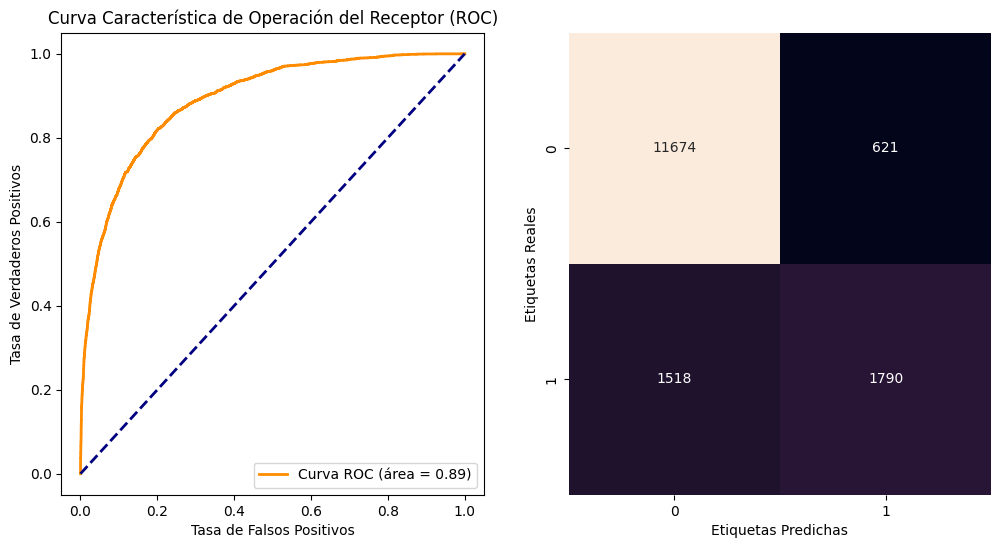

--- Métricas del Conjunto de Entrenamiento ---
Exactitud (Accuracy):  0.8633253753344763
Precisión (Precision):  0.8551326177410655
Sensibilidad (Recall):  0.8633253753344763
Puntuación F1:  0.8548121240049231
AUC(ROC):  0.744645716111543

Informe de Clasificación para el Conjunto de Entrenamiento: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     49204
           1       0.74      0.54      0.63     13207

    accuracy                           0.86     62411
   macro avg       0.81      0.74      0.77     62411
weighted avg       0.86      0.86      0.85     62411



In [417]:
log_reg_param_grid = [
    # Dividí los parámetros de esta manera para evitar warnings
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'max_iter': [100, 200, 300, 400, 500]
    },
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'saga'],
        'max_iter': [100, 200, 300, 400, 500]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'l1_ratio': [0.5],
        'max_iter': [100, 200, 300, 400, 500]
    }
]


model_lr = LogisticRegression()
model_lr, acc_lr_test, pr_lr_test, rec_lr_test, f1_lr_test, roc_auc_lr_test, param_lr = entrenar_modelo_con_busqueda_aleatoria_test(
    model_lr, log_reg_param_grid, x_train_normalizado, y_train, x_test_normalizado, y_test, cv)

model_lr, acc_lr_train, pr_lr_train, rec_lr_train, f1_lr_train, roc_auc_lr_train, param_lr = entrenar_modelo_con_busqueda_aleatoria_train(model_lr, log_reg_param_grid, x_train_normalizado, y_train, cv)


In [419]:
print(param_lr)

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 1}


# Resultados

Medidas de rendimiento en el conjunto de Test

In [422]:
accuracies = [acc_lr_test, acc_dt_test, acc_rf_test]
f_score = [f1_lr_test, f1_dt_test, f1_rf_test]
roc_auc = [roc_auc_lr_test, roc_auc_dt_test, roc_auc_rf_test]
precisions = [pr_lr_test, pr_dt_test, pr_rf_test]
recalls = [rec_lr_test, rec_dt_test, rec_rf_test]

final_df = pd.DataFrame({
    "Accuracies": accuracies,
    "F1 Scores": f_score,
    "ROC AUC": roc_auc,
    "Precision": precisions,
    "Recall": recalls
}, index=['LogisticReg', 'DecisionTree', 'RandomForest'])

final_df = final_df.round(4)
final_df


Accuracies  F1 Scores  ROC AUC  Precision  Recall
LogisticReg       0.8629     0.8546   0.7453     0.8547  0.8629
DecisionTree      0.8490     0.8396   0.7234     0.8386  0.8490
RandomForest      0.8707     0.8611   0.7479     0.8641  0.8707

Medidas de rendimiento en el conjunto de Train

In [423]:

accuracies = [acc_lr_train, acc_dt_train, acc_rf_train]
f_score = [f1_lr_train, f1_dt_train, f1_rf_train]
roc_auc = [roc_auc_lr_train, roc_auc_dt_train, roc_auc_rf_train]
precisions = [pr_lr_train, pr_dt_train, pr_rf_train]
recalls = [rec_lr_train, rec_dt_train, rec_rf_train]


final_df_train = pd.DataFrame({
    "Accuracies": accuracies,
    "F1 Scores": f_score,
    "ROC AUC": roc_auc,
    "Precision": precisions,
    "Recall": recalls
}, index=['LogisticReg', 'DecisionTree', 'RandomForest'])

final_df_train = final_df_train.round(4)
final_df_train


Accuracies  F1 Scores  ROC AUC  Precision  Recall
LogisticReg       0.8633     0.8548   0.7446     0.8551  0.8633
DecisionTree      0.8762     0.8686   0.7646     0.8700  0.8762
RandomForest      0.9735     0.9730   0.9399     0.9741  0.9735

Comparamos con la performance de entrenamiento y vemos que los valores de testeo no están muy alejados para ninguno de los modelos de los valores de training.

Random Forest muestra el mejor rendimiento con un F1 Score de 0.8611.
